<a href="https://colab.research.google.com/github/tommyj530/DisguiseFaceRecognition/blob/main/DisguiseFaceRecognitionViaTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot --quiet
!pip install split-folders
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import time
import os
import copy
import zipfile
from livelossplot import PlotLosses
import splitfolders

plt.ion()   # interactive mode

Data Organization

Disguise vs Original
Train and Validation Data

In [2]:
from zipfile import ZipFile 
file_name = "DisguiseFaceTrainTestDataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

# Split the data into "train" and "validation"
#splitfolders.ratio('DisguiseFaceDataset', output="TrainTestDataset", seed=1337, ratio=(.8, .2), group_prefix=None) 

Done


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

'''
For the project, we will use different transformations for the model 
to learn invariant features from the training dataset 
a) rotation/flip
b) de-exturized 
c) de-colorized 
d) edged enhanced 
e) salient edge map
'''

#increased_dataset = torch.utils.data.ConcatDataset([transformed_dataset,original])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = "DisguiseFaceTrainTestDataset"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Splitting data into train and validation 
'''
X_train, X_test, Y_train, Y_test = generate_train_test_pairs(1000)

trainloader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)),
                         batch_size=32, shuffle=True)
testloader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)),
                         batch_size=32, shuffle=False)

dataloaders = {
    "train": trainloader,
    "validation": testloader
}
'''

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualizing images 

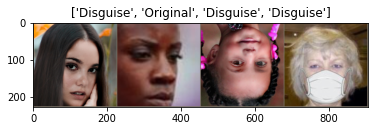

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    liveloss = PlotLosses()
    tra_acc_history = []
    val_acc_history = []


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        logs = {}
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Record training accuracy over epoch
            if phase == 'train':
                tra_acc_history.append(epoch_acc)
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            prefix = ''   
            if phase == 'val':    
                prefix = 'val_'
                val_acc_history.append(epoch_acc)

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        print()
        liveloss.update(logs)
        liveloss.send()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.set_ylabel('true: {}'.format(class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the DCNN (pre-trained) : Resnet18

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))
'''
self.labels_model = nn.Sequential(
            nn.Linear(fc_inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes), 
            nn.LogSoftmax(dim=1) # For using NLLLoss()
)
'''

model_ft.fc = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(num_ftrs, 2)    
)

model_ft.fc = nn.Linear(num_ftrs, 2)    

# Loading the parameters from previous training HERE 
#model_ft.load_state_dict(state_dict)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



512


Train and evaluate

The model seems to be overfitting by quite a bit. No need to conduct more than 30 epochs as the validation accuracy seems to reach its asymptotic limit.

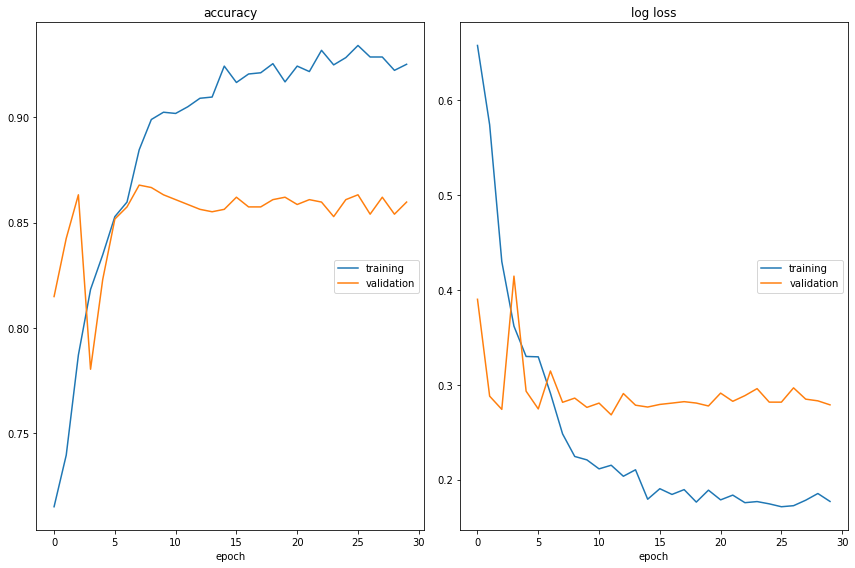

accuracy
	training         	 (min:    0.715, max:    0.934, cur:    0.925)
	validation       	 (min:    0.780, max:    0.868, cur:    0.860)
log loss
	training         	 (min:    0.171, max:    0.658, cur:    0.177)
	validation       	 (min:    0.268, max:    0.415, cur:    0.279)
Training complete in 24m 14s
Best val Acc: 0.867816


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Freezing all the network except the final layer (Need to set requires_grad == False)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(num_ftrs, 2)  
)
        
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate ONLY the FINAL layer

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Saving hyperparameters for later use

In [12]:
torch.save(model_ft.state_dict(), '30EpochsWithDropoutWithOriginalDataset.pth')

# download checkpoint file
files.download('30EpochsWithDropoutWithOriginalDataset.pth')

NameError: ignored

Visualize the model prediction with true values

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()